In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from scipy.integrate import dblquad
import ray
from tqdm import tqdm

ray.init(num_cpus=4)

2023-07-11 19:47:21,792	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.9.7
Ray version:,2.5.1


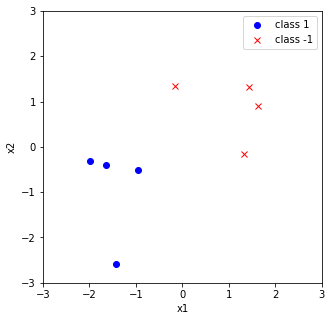

In [8]:
# Generate data
import seaborn

np.random.seed(4)
N = 4
dim = 2
X1 = np.random.normal(-1, 1, (N, dim))
X2 = np.random.normal(1, 1, (N, dim))
X = np.concatenate((X1, X2), axis=0)
y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

# Plot data
plt.figure(figsize=(5, 5))
plt.plot(X[y == 1, 0], X[y == 1, 1], 'bo', label='class 1')
plt.plot(X[y == -1, 0], X[y == -1, 1], 'rx', label='class -1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

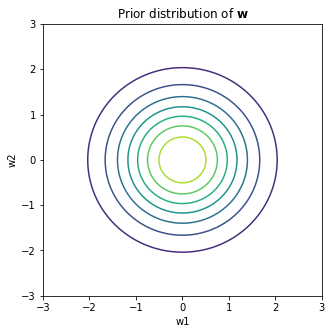

In [3]:
# prior distribution
prior = multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim))

# Contour plot of prior distribution
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i, j] = prior.pdf([X1[i, j], X2[i, j]])
plt.figure(figsize=(5, 5))
plt.contour(X1, X2, Z)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Prior distribution of $\mathbf{w}$')
plt.show()

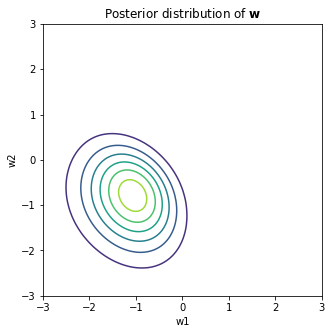

In [4]:
# Posterior distribution
def posterior(w, X, y):
    prior = multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim))
    sigmoid = 1 / (1 + np.exp(-y * np.dot(X, w)))
    return prior.pdf(w) * np.prod(sigmoid)

# Contour plot of posterior distribution
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i, j] = posterior([X1[i, j], X2[i, j]], X, y)
plt.figure(figsize=(5, 5))
plt.contour(X1, X2, Z)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Posterior distribution of $\mathbf{w}$')
plt.show()

In [5]:
# Predictive distribution with each data point
from scipy.integrate import dblquad

@ray.remote
def predictive(x_new, X, y):
    def prediction(w1, w2):
        w = np.array([w1, w2])
        return 1 / (1 + np.exp(-np.dot(w, x_new)))
    def integrand(w1, w2):
        w = np.array([w1, w2])
        return posterior(w, X, y) * prediction(w1, w2)
    return dblquad(integrand, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)[0]

100%|██████████| 10/10 [02:55<00:00, 17.51s/it]


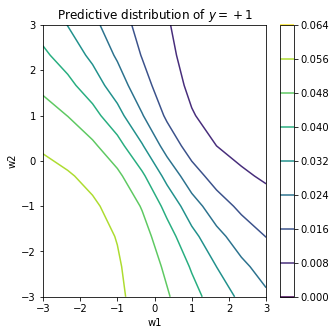

In [7]:
# Contour plot of predictive distribution
resolution = 10

x1 = np.linspace(-3, 3, resolution)
x2 = np.linspace(-3, 3, resolution)
X1, X2 = np.meshgrid(x1, x2)
Z = np.zeros((resolution, resolution))

for i in tqdm(range(resolution)):
    for j in range(resolution):
        Z[i, j] = ray.get(predictive.remote([X1[i, j], X2[i, j]], X, y))
plt.figure(figsize=(5, 5))
plt.contour(X1, X2, Z)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Predictive distribution of $y=+1$')
plt.colorbar()
plt.show()